In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [94]:
data = pd.read_csv('diamonds.csv')
print(len(data))
data.head()

53940


,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


This dataset contains the prices and atributes of 53940 diamonds. There are 10 atributes:
* carat - physical weight measured in metric carats
* cut - quality of cut
* color - color quality of the diamond
* clarity - absence of the inclusions and blemishes
* depth - total height from bottom tip to the top flat surface
* table - total width of top flat surface
* price - in Us dollars
* x, y, z - dimensions (x-length, y-width, z-depth)

Categorical features: Cut, Color, Clarity
Numerical fatures: CArat, Depth, Table, Price, x, y, z

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [96]:
data.isnull().any()

Unnamed: 0    False
carat         False
cut           False
color         False
clarity       False
depth         False
table         False
price         False
x             False
y             False
z             False
dtype: bool

We can see the types of data in each column but more importantly - there aren't any null values in the data.

In [97]:
data = data.drop(['Unnamed: 0', 'clarity', 'color'], axis=1)
data.head()

,carat,cut,depth,table,price,x,y,z
0,0.23,Ideal,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,63.3,58.0,335,4.34,4.35,2.75


Removing redundant column: Unnamed:0 and others that will not be used in future analysis.

In [98]:
data.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Having min values = 0 in x,y,z means that there are some incorrect values. I'll drop all rows with dimensions '0'.

In [99]:
data = data[(data[['x','y','z']] != 0).all(axis=1)]
data.describe()

,carat,depth,table,price,x,y,z
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,0.797698,61.749514,57.456834,3930.993231,5.731627,5.734887,3.540046
std,0.473795,1.432331,2.234064,3987.280446,1.119423,1.140126,0.702530
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5323.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


Replacing rows with words to representantive grade numbers to ease future processing:

In [100]:
data.value_counts('cut')

cut
Ideal        21548
Premium      13780
Very Good    12081
Good          4902
Fair          1609
dtype: int64

There are 5 possible grades of possible diamonds cut - they will be raplaced as:
* Ideal - 5
* Premium - 4
* Very Good - 3
* Good - 2
* Fair - 1

Because of that this feature will be converted into numerical feature.


In [101]:
data['cut'] = data['cut'].replace('Ideal', 5)
data['cut'] = data['cut'].replace('Premium', 4)
data['cut'] = data['cut'].replace('Very Good', 3)
data['cut'] = data['cut'].replace('Good', 2)
data['cut'] = data['cut'].replace('Fair', 1)
data.value_counts('cut')

cut
5    21548
4    13780
3    12081
2     4902
1     1609
dtype: int64

In [102]:
data.head()

,carat,cut,depth,table,price,x,y,z
0,0.23,5,61.5,55.0,326,3.95,3.98,2.43
1,0.21,4,59.8,61.0,326,3.89,3.84,2.31
2,0.23,2,56.9,65.0,327,4.05,4.07,2.31
3,0.29,4,62.4,58.0,334,4.20,4.23,2.63
4,0.31,2,63.3,58.0,335,4.34,4.35,2.75


After these slight corrections of the dataset, now we have data that we can process with analysis.

Checking corelation between features:

<AxesSubplot:>

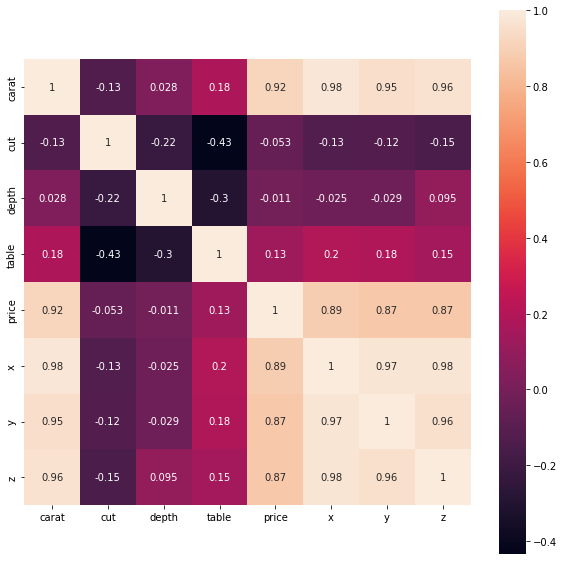

In [103]:
plt.figure(figsize=(10, 10))
corr = data.corr()
sns.heatmap(data=corr, square=True , annot=True, cbar=True)

Conclusions:
* depth is inversely related to price
* price is correlated to carat weigth and x, y, z
* carat weigth has the biggest influence in the matter of the price

Looking for outliers:

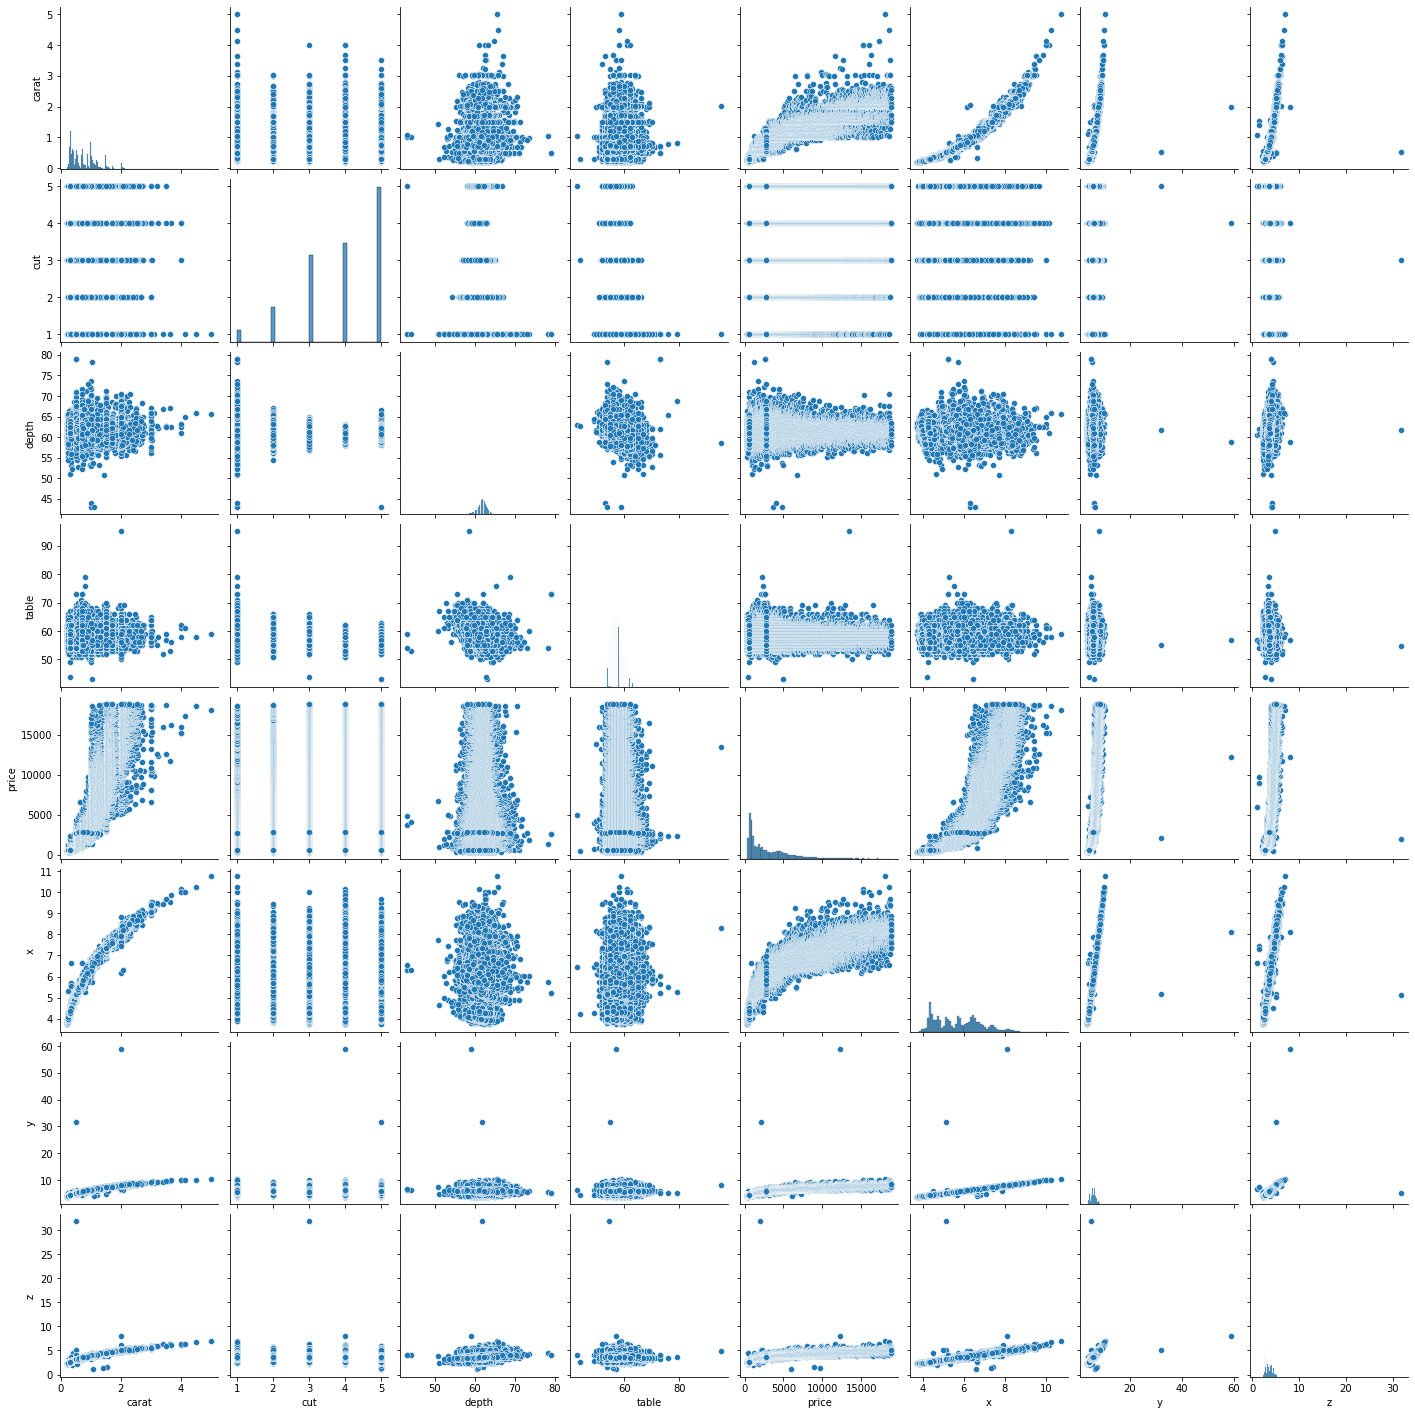

In [104]:
sns.pairplot(data)

We can see that there are some points that are far from the rest. By removing them we can have much more consistent data.

In [105]:
data = data[(data["depth"]>45) & (data["depth"]<75)]
data = data[(data["table"]<75) & (data["table"]>45)]
data = data[(data["y"]<30)]
data = data[(data["z"]<30)]

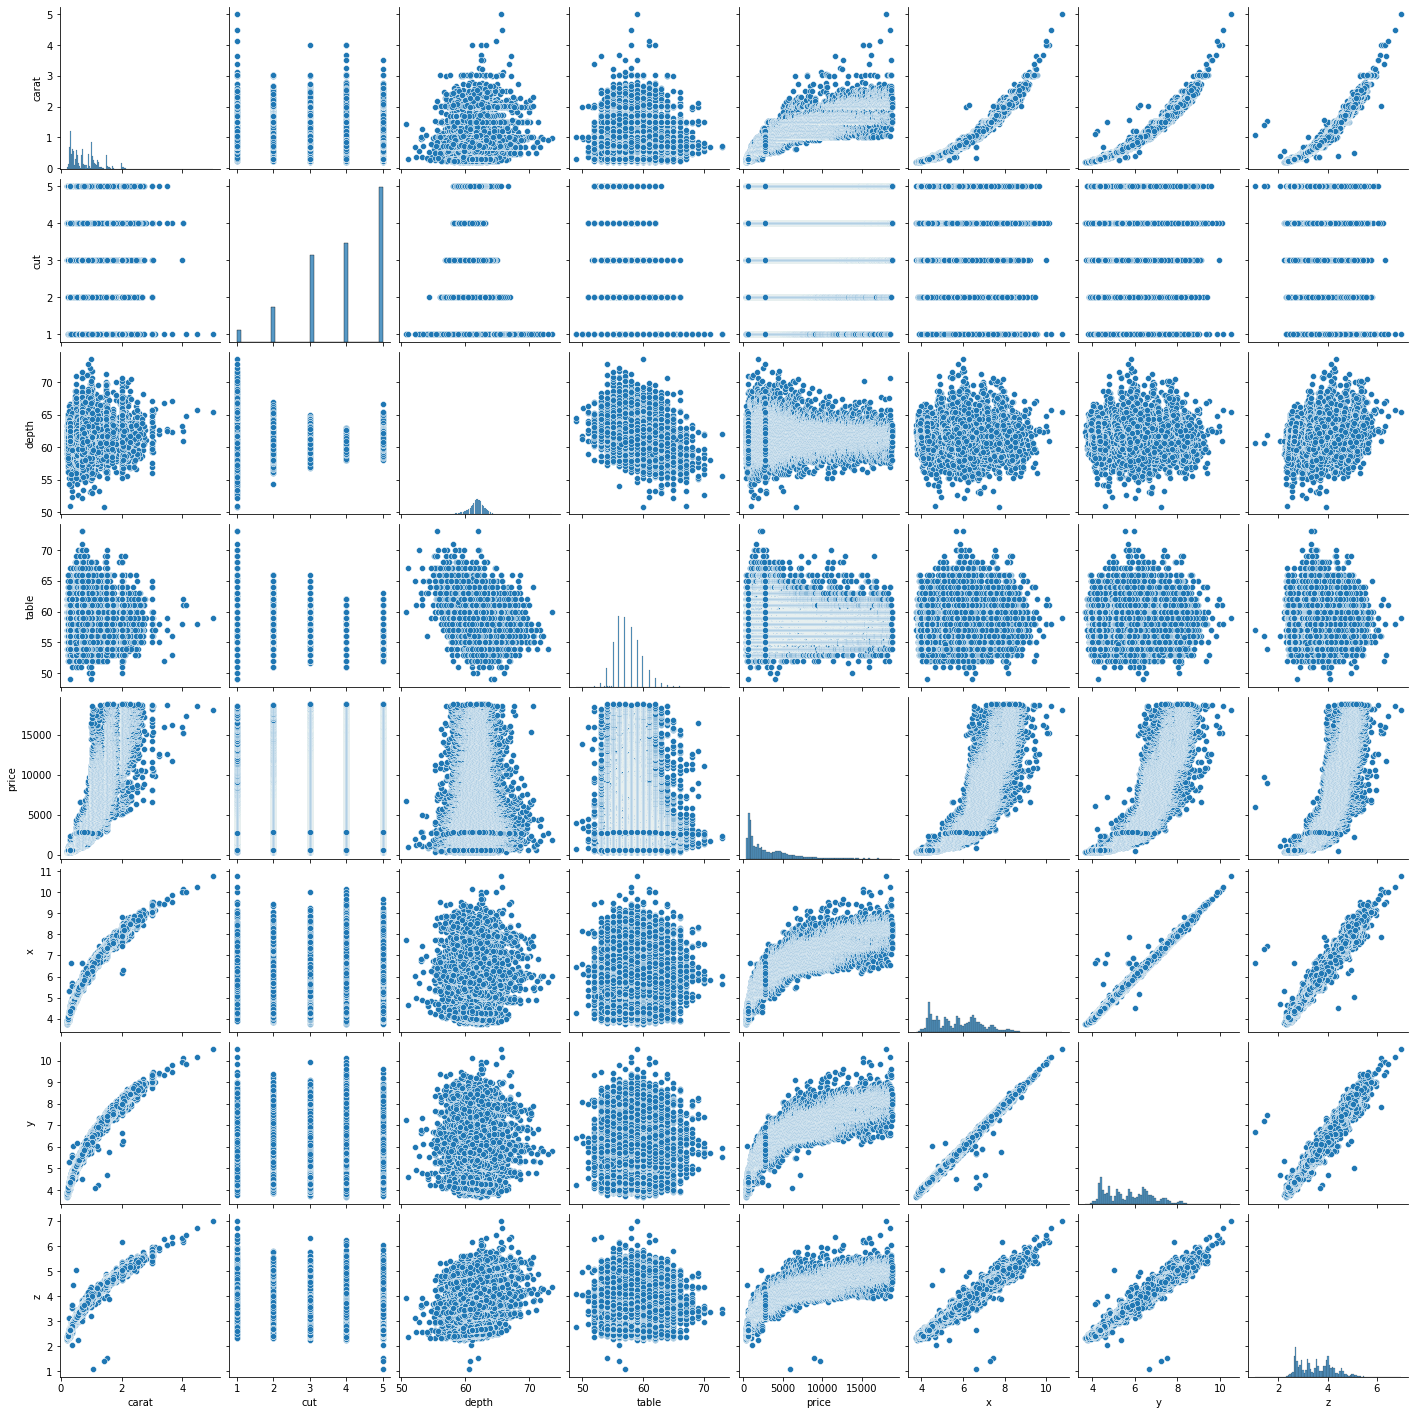

In [106]:
sns.pairplot(data)

Creating simple linear regression model of carat to price:

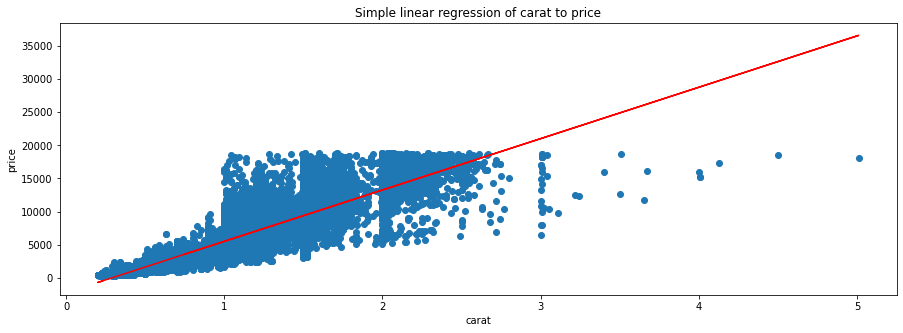

Mean squarred error equals:  2395274.555899162
Score:  0.8493407358400427


In [107]:
X = data.carat.values.reshape(-1, 1)
y = data.price.values.reshape(-1)
model = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1)
model.fit(X, y)
y_pred = model.predict(X)
plt.figure(figsize=(15, 5))
plt.scatter(X, y)
plt.plot(X, y_pred, color='red')
plt.title('Simple linear regression of carat to price')
plt.xlabel('carat')
plt.ylabel('price')
plt.show()
first_error = mean_squared_error(y_pred, y)
print('Mean squarred error equals: ', first_error)
print('Score: ', model.score(X, y))


Finding a better model using polynomial regression models that can handle unknown data:

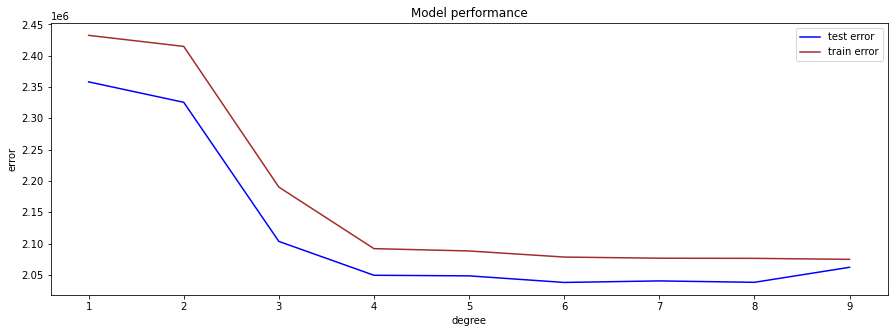

In [108]:
errors_train = []
errors_test = []
for order in range(1, 10):
    model = LinearRegression()
    poly = PolynomialFeatures(order, include_bias = False)
    X_order = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_order, y, test_size=0.5, random_state=40)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    errors_train.append(mean_squared_error(y_pred, y_train))
    y_pred = model.predict(X_test)
    errors_test.append(mean_squared_error(y_pred, y_test))
    
plt.figure(figsize=(15, 5))
plt.plot(range(1,10), errors_test, label='test error', c='blue')
plt.plot(range(1,10), errors_train, label='train error', c='brown')
plt.title('Model performance')
plt.xlabel('degree')
plt.ylabel('error')
plt.legend()
plt.show()

After splitting data into training and test samples and creating polynomial regression models we create the plot of mse of test and train models. The test error doesn't change much after degree 5 and the train error doesn't change much at degree 6. This means that the best candidates are degree 5 to 6 as they have best and sufficient train/test errors.

Lets see these models and compare whether degree 6 plot looks the best:

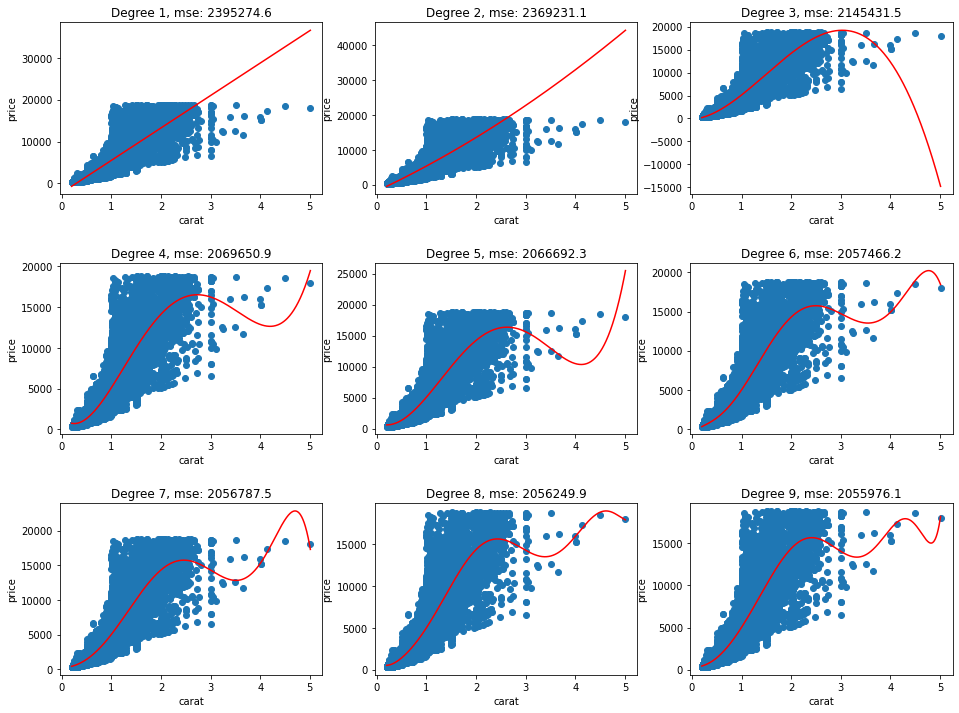

In [109]:
plt.figure(figsize=(16, 12))
second_error = 0
for order in range(1, 10):
    poly = PolynomialFeatures(order, include_bias=False)
    X_order = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_order, y, test_size=0.5, random_state=40)
    model_poly = LinearRegression()
    y_pred = model_poly.fit(X_order, y).predict(X_order)
    test = model_poly.predict(X_test)
    train = model_poly.predict(X_train)
    plt.subplot(3, 3, order)
    plt.subplots_adjust(hspace=0.4)
    if order == 6: second_error = mean_squared_error(y_pred, y)
    plt.scatter(X, y)
    x = np.argsort(X.ravel())
    X_reshaped = X.reshape(-1)
    model_poly = np.poly1d(np.polyfit(X_reshaped[x], y_pred[x], order))
    space = np.linspace(min(X), max(X), 1000)
    plt.plot(space, model_poly(space), color='r')
    plt.title(f'Degree {order}, mse: {mean_squared_error(y_pred, y):.8}')
    plt.xlabel('carat')
    plt.ylabel('price')


In [110]:
print('This model with degree 6 is better by {0:.0%} from previous'.format((first_error-second_error)/first_error))

This model with degree 6 is better by 14% from previous


As we can see - this model has a better mse and the plot line is much more adaptive than a simple linear function.

Now i will look for a model that uses multiple features that gives a better mse:

In [111]:
X = data[['carat', 'cut', 'depth']].values.reshape(-1,3)
y = data.price.values.reshape(-1)
poly = PolynomialFeatures(6, include_bias = False)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=40)
model = LinearRegression() 
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
third_error = mean_squared_error(y_pred, y_test)
print("Mean squared error equals: {0}".format(third_error))

Mean squared error equals: 1875779.8662053884


In [112]:
print('This model is better by {0:.0%} from previous'.format((second_error-third_error)/second_error))
print('This model is better by {0:.0%} from first'.format((first_error-third_error)/first_error))

This model is better by 9% from previous
This model is better by 22% from first


Now I'll use similar process to make a model that predicts carat by using price and other atributes:

In [113]:
X = data[['price', 'cut', 'depth']].values.reshape(-1,3)
y = data.carat.values.reshape(-1)
poly = PolynomialFeatures(5, include_bias = False)
X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=40)
model = LinearRegression() 
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)
print("Mean squared error equals: {0}".format(mean_squared_error(y_pred, y_test)))

Mean squared error equals: 0.021840887576266458


The mse from this model is vastly smaller from the model that predicted price. This means it is way easier to predict carat weigth by price than price by carat weigth.

Using different regression models:

In [114]:
X = data[['carat', 'cut', 'depth']].values.reshape(-1,3)
y = data.price.values.reshape(-1)
lasso = Lasso()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=40)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print(f'Score: {lasso.score(X_test, y_test)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')

Score: 0.8574686298730848
Mean squared error: 2259851.6563282614


In [115]:
X = data[['carat', 'cut', 'depth']].values.reshape(-1,3)
y = data.price.values.reshape(-1)
ridge = Ridge()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=40)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print(f'Score: {ridge.score(X_test, y_test)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')

Score: 0.8574760715631577
Mean squared error: 2259733.667455901


In [116]:
X = data[['carat', 'cut', 'depth']].values.reshape(-1,3)
y = data.price.values.reshape(-1)
forest = RandomForestRegressor()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=40)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(f'Score: {forest.score(X_test, y_test)}')
print(f'Mean squared error: {mean_squared_error(y_test, y_pred)}')

Score: 0.8640440157279744
Mean squared error: 2155598.1393520455


Lasso, Ridge regression  and RandomForestRegressor models seem to return a bit better results than the first simple Linear regression model.

In assignment 3 we learned about formalitics of Linear regression. at the beggining we learned how to calculate the cost function and how to find best slope for the line among evaluated with cost function. Lets see how it looks at our dimond data:

In [121]:
def predict(b, X):
    return np.dot(X, b)

def cost(y_pred, y_true):
    return round((((np.linalg.norm(y_pred-y_true))**2)/y_true.shape[0]), 10)

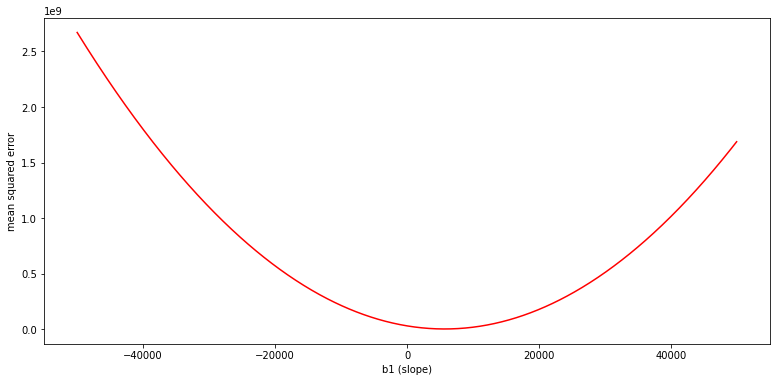

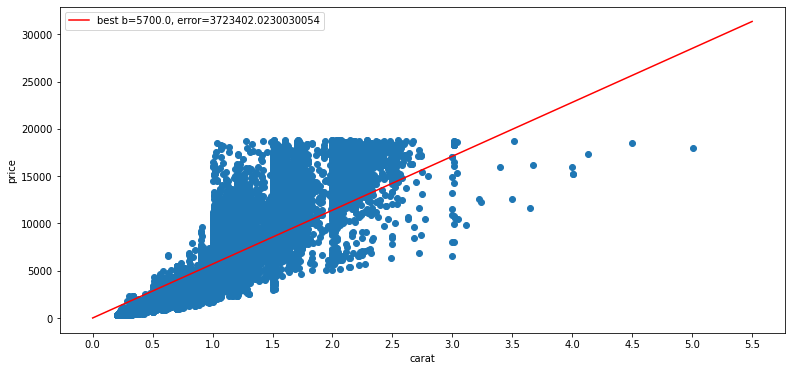

In [122]:
X = data.carat.values.reshape(-1, 1)
y = data.price.values.reshape(-1, 1)

plt.figure(figsize=(13, 6))
b = [b_ for b_ in np.arange(-0.5e5, 0.5e5, step=100)]
costs = [cost(predict(b_, X), y) for b_ in b]
plt.plot(b, costs, c='r')
plt.xlabel('b1 (slope)')
plt.ylabel('mean squared error')
plt.show()
plt.figure(figsize=(13, 6))
x_ = np.arange(0, 6, step=0.5)
y_ = b[costs.index(min(costs))]*x_
plt.plot(x_, y_, c='r', label=f'best b={b[costs.index(min(costs))]}, error={min(costs)}')
plt.scatter(X, y)
plt.xticks(x_)
plt.xlabel('carat')
plt.ylabel('price')
plt.legend()
plt.show()


After getting best b value, we are constructing a linear function that tries to fit in our dataset. It looks like the line is a bit highter than the result from first plot using linear regression. It is affected by high density of points.

Further into assignment 3 we learned how to standardize the data, estimate the b using GDM method and  present the dependence of cost function's of value on vector b using heatmap.

In [123]:
def standardize(X):
    means = [np.mean(X, axis=0)]
    sds = [np.std(X, axis=0)]
    return (np.array(X)-means)/sds, means, sds

def destandardize(X, means, sds):
    return X*sds+means

def gradient(b, X, y):
    return np.dot(2*np.transpose(X),(np.dot(X, b)-y))/y.shape[0]

def gradient_descent_step(b, X, y, lr):
    return b-gradient(b, X, y)*lr

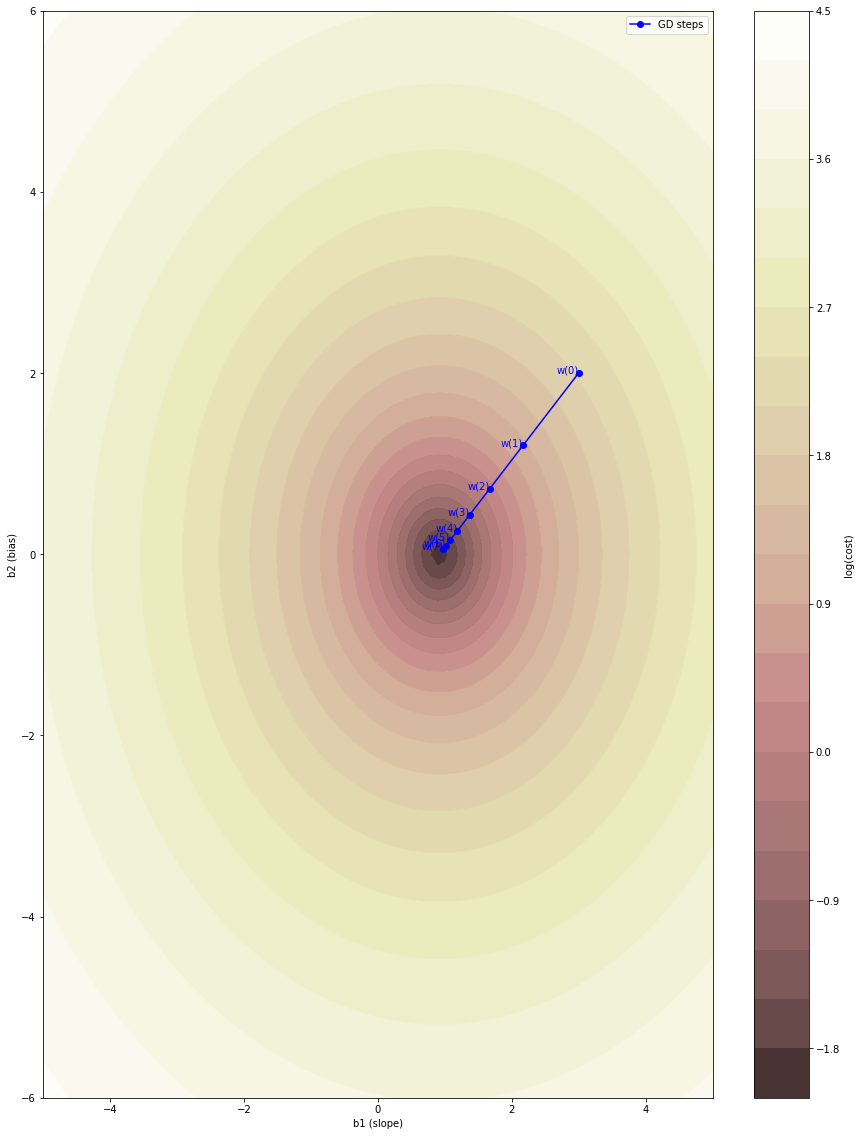

In [135]:
X_new, _, _ = standardize(X[:, 0].reshape(-1, 1))
X_new = np.c_[(X_new, np.ones((X.shape[0], 1)))]
y_new, _, _ = standardize(y)
b = np.array([[3], [2]])

nb_of_bs = 101  
b1 = np.linspace(-5, 5, num=nb_of_bs) 
b2 = np.linspace(-6, 6, num=nb_of_bs) 
b_x, b_y = np.meshgrid(b1, b2) 
cost_arr_2d = np.zeros((nb_of_bs, nb_of_bs)) 

for i in range(nb_of_bs):
    for j in range(nb_of_bs):
        cost_arr_2d[i, j] = cost(
            predict(np.array([[b_x[i, j]], [b_y[i, j]]]), X_new), y_new)
        
plt.figure(figsize=(15,20)) 
plt.contourf(b_x, b_y, np.log(cost_arr_2d), 20, alpha=0.9, cmap=cm.pink)
cbar = plt.colorbar()
cbar.ax.set_ylabel('log(cost)')
plt.xlabel("b1 (slope)")
plt.ylabel("b2 (bias)")
steps = [b]
names = ['w(0)']
for i in range(7):
    b = gradient_descent_step(b, X_new, y_new, 0.2)
    steps.append(b)
    names.append(f'w({i+1})')
steps = np.reshape(steps, (-1, 2))
plt.plot(steps[:,0], steps[:,1], label='GD steps', c='b', marker='o')
for i, txt in enumerate(names):
    plt.annotate(txt, (steps[:,0][i], steps[:,1][i]), c='b', ha='right')
plt.legend()
plt.show()

* After standardizing the data we can compare it.
* Using GDM we are getting close to the minimum (darkest point on the heatmap) after about 7 steps of this algorithm.
* From the heatmap we can see that the minimum lies in range where the bias is close to 0 and the slope is around zero.